In [1]:
import functools
from absl import logging

import jax
from jax import random
import jax.numpy as jnp

from flax import jax_utils
from flax.training import common_utils

import ml_collections

from data import input_pipeline
import models

import wandb

import numpy as np
import utils

from configs.eval_merge import get_config

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from utils import restore_checkpoint

import merging
import models


from trainer import compute_metrics 

2024-07-29 17:07:31.357724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:07:31.389767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:07:31.389811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 17:07:32.899968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/h/ekansh/condaenvs/jax-0.4.23/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLE

In [2]:
def get_metrics(metrics):
  return common_utils.stack_forest(metrics)

  
@functools.partial(jax.jit, static_argnums=(0,))
def eval_step(apply_fn, params, batch):
    variables = {'params': params}
    logits = apply_fn(variables, batch['image'])
    metrics = compute_metrics(logits, batch['label'])  
    return metrics


def compute_loss_and_accuracy(params, apply_fn, dataset, nbatches=None):
  eval_iter = input_pipeline.prefetch(dataset, 10, None)
  eval_metrics = []
  ix = 0
  for eval_batch in eval_iter:
      metrics = eval_step(apply_fn, params, eval_batch)
      eval_metrics.append(metrics)
      ix+=1
      if nbatches is not None:
          if ix >= nbatches:
              break
  
  eval_metrics = get_metrics(eval_metrics)
  summary = {
          f'eval_{k}': v
          for k, v in jax.tree_util.tree_map(
              lambda x: x.mean(), eval_metrics
          ).items()
      }

  return summary['eval_loss'], summary['eval_accuracy']



In [3]:
config = get_config(f'VGG16,cifar10.cifar100.eurosat.resisc45.stanford_dogs,mgda-merging')

# config = get_config(f'VGG16,cifar10.cifar100.eurosat.resisc45,mgda-merging')
config.width_multiplier = 2
config.cifar10.model_dir = 'checkpoint/VGG16x2/scratch/cifar10_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980172'
config.cifar10.init_model_dir = 'checkpoint/VGG16x2/scratch/cifar10_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980172/init'
config.cifar100.model_dir = 'checkpoint/VGG16x2/scratch/cifar100_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980173/'
config.cifar100.init_model_dir = 'checkpoint/VGG16x2/scratch/cifar100_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980173/init'
config.eurosat.model_dir = 'checkpoint/VGG16x2/scratch/eurosat_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980176/'
config.eurosat.init_model_dir = 'checkpoint/VGG16x2/scratch/eurosat_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980176/init'
config.resisc45.model_dir = 'checkpoint/VGG16x2/scratch/resisc45_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980183/'
config.resisc45.init_model_dir = 'checkpoint/VGG16x2/scratch/resisc45_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980183/init'
config.stanford_dogs.model_dir = 'checkpoint/VGG16x2/scratch/stanford_dogs_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980184/'
config.stanford_dogs.init_model_dir = 'checkpoint/VGG16x2/scratch/stanford_dogs_96/sgd/cosine_decay/peak_lr_1e-1/seed_0/12980184/init'
config.cifar10.pp.crop = 96
config.cifar100.pp.crop = 96
config.eurosat.pp.crop = 96
config.resisc45.pp.crop = 96
config.stanford_dogs.pp.crop = 96


In [14]:
config = get_config(f'VGG16,cifar10.cifar100.eurosat.resisc45.stanford_dogs,mgda-merging')
config.width_multiplier = 2
config.cifar10.model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar10_96/sgd/epochs_40_0/cosine_1e-2/seed_0/12980603/'
config.cifar10.init_model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar10_96/sgd/epochs_40_0/cosine_1e-2/seed_0/12980603/init'
config.cifar100.model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar100_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980685'
config.cifar100.init_model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar100_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980685/init'
config.eurosat.model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/eurosat_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980688'
config.eurosat.init_model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/eurosat_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980688/init'
config.resisc45.model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/resisc45_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980693/'
config.resisc45.init_model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/resisc45_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980693/init'
config.stanford_dogs.model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/stanford_dogs_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980694'
config.stanford_dogs.init_model_dir = 'checkpoint/VGG16x2/finetuned_imagenet2012_96_13/stanford_dogs_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980694/init'
config.cifar10.pp.crop = 96
config.cifar100.pp.crop = 96
config.eurosat.pp.crop = 96
config.resisc45.pp.crop = 96
config.stanford_dogs.pp.crop = 96


In [25]:
from configs.eval_merge import get_config
config = get_config(f'ViTB32,cifar10.cifar100.eurosat.stanford_dogs,mgda-merging')
config.cifar10.model_dir = 'experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.cifar10.init_model_dir = 'experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.cifar100.model_dir = 'experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.cifar100.init_model_dir = 'experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.eurosat.model_dir = 'experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.eurosat.init_model_dir = 'experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.stanford_dogs.model_dir = 'experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config.stanford_dogs.init_model_dir = 'experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.resisc45.model_dir = 'experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.resisc45.init_model_dir = 'experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'

config.cifar10.pp.crop = 224
config.cifar100.pp.crop = 224
config.eurosat.pp.crop = 224
config.resisc45.pp.crop = 224

In [4]:
from configs.eval_merge import get_config
config = get_config(f'ViTB32,cifar10.cifar100,mgda-merging')
config.cifar10.model_dir = 'experiments/ViT-B-32/FT_sgd_imagenet/cifar10/adam_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.cifar10.init_model_dir = 'experiments/ViT-B-32/FT_sgd_imagenet/cifar10/adam_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.cifar100.model_dir = 'experiments/ViT-B-32/FT_sgd_imagenet/cifar100/adam_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.cifar100.init_model_dir = 'experiments/ViT-B-32/FT_sgd_imagenet/cifar100/adam_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init/'
# config.eurosat.model_dir = 'experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
# config.eurosat.init_model_dir = 'experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
# config.stanford_dogs.model_dir = 'experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
# config.stanford_dogs.init_model_dir = 'experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
# config.resisc45.model_dir = 'experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
# config.resisc45.init_model_dir = 'experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'

config.cifar10.pp.crop = 224
config.cifar100.pp.crop = 224
config.eurosat.pp.crop = 224
config.resisc45.pp.crop = 224

In [5]:
datasets = config.datasets
dataset_info_ls = [input_pipeline.get_dataset_info(dataset, config[dataset].pp['train']) for dataset in config.datasets]
num_classes = [dataset_info['num_classes'] for dataset_info in dataset_info_ls] 
num_train_examples = [dataset_info['num_examples'] for dataset_info in dataset_info_ls]

_, ds_test_ls = input_pipeline.get_datasets_for_mtl(config, datasets)



In [6]:
ntasks = len(num_classes)
model_ls = []
for nclass in num_classes:
    model_ls += [models.create_model(
                    model_cls= getattr(models, config.model), 
                    num_classes=nclass, 
                    width_multiplier=config.width_multiplier,
                    projection_dim=512, 
                    half_precision=config.half_precision) ]

## Get expert + init  models
expert_params_ls = []
init_params_ls = []
for dataset in datasets:
    print(f"Loading init and expert models for {dataset}.")
    expert_params_ls += [restore_checkpoint(config[dataset].model_dir)['params']]
    init_params_ls += [restore_checkpoint(config[dataset].init_model_dir)['params']]  



Loading init and expert models for cifar10.
Loading init and expert models for cifar100.


In [7]:

## Compute task vectors
task_vectors = [utils.tree_subtract({
    'encoder' : params['encoder'],
    'visual_projection' : params['visual_projection']
}, {
    'encoder' : init_params['encoder'],
    'visual_projection' : init_params['visual_projection']
}) for params, init_params  in zip(expert_params_ls, init_params_ls)]  

perf_gain = lambda acc, init_acc: (acc - init_acc) / init_acc
perf_drop = lambda acc, expert_acc: (expert_acc - acc) / expert_acc


In [8]:
from utils import cosine_similarity

cosine_sim_tv = np.zeros((ntasks, ntasks))
for i in range(ntasks):
    for j in range(i, ntasks):
        cosine_sim_tv[i, j] = cosine_similarity(task_vectors[i], task_vectors[j])
        cosine_sim_tv[j, i] = cosine_sim_tv[i, j]

In [26]:
cosine_similarity(task_vectors[4], task_vectors[2])

Array(0.9991379, dtype=float32)

/tmp/ipykernel_29764/1104765320.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

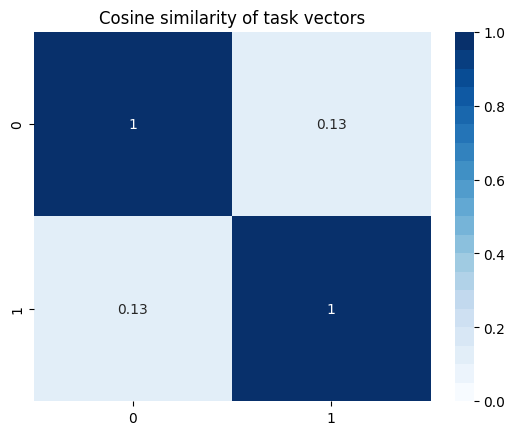

In [9]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(cosine_sim_tv, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

In [63]:
cosine_similarity(utils.add_trees(task_vectors[:2]), task_vectors[3])

Array(0.06073131, dtype=float32)

In [37]:
len(task_vectors[:3])

3

/tmp/ipykernel_19936/2698817184.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of gradients')

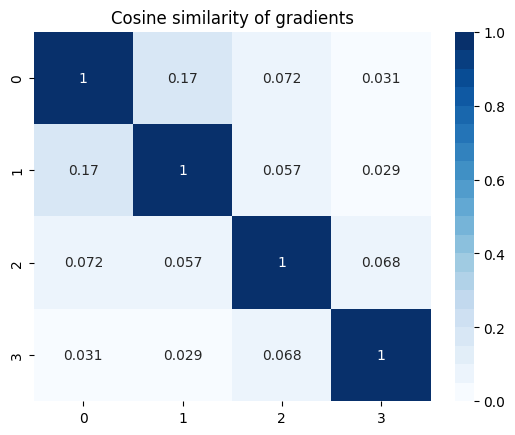

In [7]:
from min_norm_solver import find_min_norm_element_FW

normalized_task_vectors = [utils.normalize_tree(t)[0] for t in task_vectors]
print(find_min_norm_element_FW(normalized_task_vectors)[0])
print(find_min_norm_element_FW(task_vectors)[0])




[0.23491642 0.24036642 0.25369351 0.27102367]
[0.15530696 0.03245251 0.63068806 0.18155248]


In [11]:
ix = 0
loss = []
accs = []
for lam in np.linspace(0,1,10):
    params = utils.lerp(lam, init_params_ls[ix], expert_params_ls[ix])
    merged_params = {
        'encoder': params['encoder'],
        'visual_projection': params['visual_projection'],
        'logit_scale': expert_params_ls[ix]['logit_scale'], 
        'classifier': expert_params_ls[ix]['classifier']
        }
    merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches = 10)
    loss += [merged_loss]   
    accs += [merged_accuracy]   
    

2024-07-29 17:45:00.357453: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-29 17:45:02.537712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-29 17:45:04.113882: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

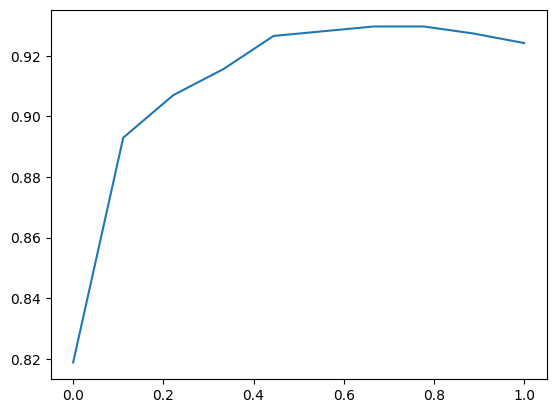

In [13]:
import matplotlib.pyplot as plt

# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

In [106]:
import utils

In [107]:
len(task_vectors)

4

In [83]:
for dataset, ds_test, model, init_params,  params in zip(config.datasets, ds_test_ls, model_ls, init_params_ls, expert_params_ls):
    print(dataset)
    merged_params = {
        'encoder': utils.tree_add(init_params['encoder'], merged_task_vector['encoder']),
        'visual_projection': utils.tree_add(init_params['visual_projection'], merged_task_vector['visual_projection']),
        'logit_scale': params['logit_scale'], 
        'classifier': params['classifier']
        }
    merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model.apply, ds_test)
    print(merged_accuracy)    


cifar10


2024-07-26 12:42:19.769302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.95552886
cifar100
0.3731971


2024-07-26 12:42:28.818453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [112]:
for i in range(4):
    print(compute_loss_and_accuracy(expert_params_ls[i], model_ls[i].apply, ds_test_ls[i]))

2024-07-26 12:57:51.872500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(0.16305833, 0.9582332)


2024-07-26 12:57:59.217605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(0.9678351, 0.79677486)


2024-07-26 12:58:02.548940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(0.07626327, 0.9750744)
(0.42791477, 0.9039714)


2024-07-26 12:58:06.438524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [113]:
for i in range(4):
    print(compute_loss_and_accuracy(init_params_ls[i], model_ls[i].apply, ds_test_ls[i]))

2024-07-26 12:58:13.834904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(nan, 0.54717547)


2024-07-26 12:58:21.195879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(nan, 0.31410256)


2024-07-26 12:58:23.280734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1.1593153, 0.63095236)
(2.4498072, 0.34830728)


2024-07-26 12:58:25.873736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [114]:
n_mgda_vec = merging.compute_normalized_mgda_vector(task_vectors, np.mean([utils.tree_norm(t) for t in task_vectors]))
mgda_vec = merging.compute_mgda_vector(task_vectors)

In [115]:
np.mean([utils.tree_norm(t) for t in task_vectors])

5.099428

In [116]:
tv_vec = utils.add_trees(task_vectors)

In [117]:
find_min_norm_element_FW(task_vectors)[0]

array([0.15530696, 0.03245251, 0.63068806, 0.18155248])

In [119]:
for ix in range(4):
    print(datasets[ix])
    merged_accuracy_ls = []
    for lam in np.linspace(.1, 1.0, 20):
        merged_params = {
            'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, tv_vec['encoder'])),
            'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,tv_vec['visual_projection'])),
            'logit_scale': expert_params_ls[ix]['logit_scale'], 
            'classifier': expert_params_ls[ix]['classifier']
            }
        merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
        merged_accuracy_ls += [merged_accuracy]
    print(max(merged_accuracy_ls))
        

cifar10
0.8625
cifar100
0.5453125
eurosat
0.7992188
resisc45
0.5578125


In [120]:
for ix in range(4):
    print(datasets[ix])
    merged_accuracy_ls = []
    for lam in np.linspace(.1, 1.0, 20):
        merged_params = {
            'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, n_mgda_vec['encoder'])),
            'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,n_mgda_vec['visual_projection'])),
            'logit_scale': expert_params_ls[ix]['logit_scale'], 
            'classifier': expert_params_ls[ix]['classifier']
            }
        merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
        merged_accuracy_ls += [merged_accuracy]
    print(max(merged_accuracy_ls))


cifar10
0.7640625
cifar100
0.3796875
eurosat
0.90703124
resisc45
0.55390626


In [121]:
for ix in range(4):
    print(datasets[ix])
    merged_accuracy_ls = []
    for lam in np.linspace(.1, 1.0, 20):
        merged_params = {
            'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, mgda_vec['encoder'])),
            'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,mgda_vec['visual_projection'])),
            'logit_scale': expert_params_ls[ix]['logit_scale'], 
            'classifier': expert_params_ls[ix]['classifier']
            }
        merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
        merged_accuracy_ls += [merged_accuracy]
    print(max(merged_accuracy_ls))


cifar10
0.6671875
cifar100
0.3140625
eurosat
0.9453125
resisc45
0.45703125


0.1 0.30546874
0.14500000000000002 0.3328125
0.19 0.35625
0.23500000000000001 0.38203126
0.28 0.40390626
0.32499999999999996 0.421875
0.37 0.4375
0.41500000000000004 0.44765624
0.45999999999999996 0.46640626
0.505 0.4796875
0.5499999999999999 0.4984375
0.595 0.5132812
0.64 0.5109375
0.6849999999999999 0.521875
0.73 0.5179688
0.7749999999999999 0.5203125
0.82 0.5234375
0.865 0.528125
0.9099999999999999 0.5257813
0.955 0.5289062
1.0 0.5257813


In [96]:
mgda_vec = merging.compute_mgda_vector(task_vectors)

In [97]:
ix = 0
for lam in np.linspace(.1, 1.0, 21):
    merged_params = {
        'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, mgda_vec['encoder'])),
        'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,mgda_vec['visual_projection'])),
        'logit_scale': expert_params_ls[ix]['logit_scale'], 
        'classifier': expert_params_ls[ix]['classifier']
        }
    merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
    print(lam, merged_accuracy)


0.1 0.64140624
0.14500000000000002 0.6859375
0.19 0.72734374
0.23500000000000001 0.76484376
0.28 0.7914063
0.32499999999999996 0.8257812
0.37 0.8515625
0.41500000000000004 0.86796874
0.45999999999999996 0.8796875
0.505 0.890625
0.5499999999999999 0.90703124
0.595 0.9203125
0.64 0.9273437
0.6849999999999999 0.92890626
0.73 0.934375
0.7749999999999999 0.93828124
0.82 0.9421875
0.865 0.946875
0.9099999999999999 0.9476563
0.955 0.9515625
1.0 0.95390624


In [99]:
ix = 1
for lam in np.linspace(.1, 1.0, 21):
    merged_params = {
        'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, mgda_vec['encoder'])),
        'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,mgda_vec['visual_projection'])),
        'logit_scale': expert_params_ls[ix]['logit_scale'], 
        'classifier': expert_params_ls[ix]['classifier']
        }
    merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
    print(lam, merged_accuracy)

0.1 0.29765624
0.14500000000000002 0.31328124
0.19 0.33046874
0.23500000000000001 0.35234374
0.28 0.36796874
0.32499999999999996 0.3796875
0.37 0.38984376
0.41500000000000004 0.39375
0.45999999999999996 0.3984375
0.505 0.40703124
0.5499999999999999 0.41171876
0.595 0.4140625
0.64 0.42421874
0.6849999999999999 0.4203125
0.73 0.4203125
0.7749999999999999 0.41640624
0.82 0.41015625
0.865 0.40625
0.9099999999999999 0.40234375
0.955 0.38671875
1.0 0.38046876
